In [1]:
from Gridworld import Gridworld

In [2]:
game = Gridworld(size=4, mode='static')

In [3]:
game.makeMove('d')
game.makeMove('u')
game.makeMove('l')
game.display()

array([['+', '-', 'P', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.reward()

-1

In [5]:
game.board.render_np()

array([[[0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [8]:
# 定义模型

import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4)
)

loss_fn = torch.nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r'
}

In [35]:
gamma = 0.9
epsilon = 1.0

epochs = 1000
losses = []

for epoch in range(epochs):
    game = Gridworld(size=4, mode='static')
    state1_ = game.board.render_np().reshape(1, -1)  # 格式化为 (1, 4x4x4)，第一个维度是 torch 中 batch，这里的bach==1
    state1_ = state1_ + np.random.rand(*state1_.shape) / 10.0    # p68，很好的解释了这里为什么要加 noise
    state1 = torch.from_numpy(state1_).float()
    game_over = 0
    while game_over == 0:
        # 计算 Q-fun 的值，表示在当前状态（t1）下的每个 action 的 value 期望
        qval = model(state1)
        qval_ = qval.data.numpy()
        print('qval', qval)
        
        # 获取下一步 action，去 q-val 最大的那个 action
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        print('action:', action_)
        action = action_set[action_] # type: ignore
        
        # 和环境产生互动，让游戏进入下一个状态(t2)
        game.makeMove(action)
        
        # 根据 p79 的 Q-learning update rule 公式来构建 loss fn
        state2_ = game.board.render_np().reshape(1, -1)
        state2_ = state2_ + np.random.rand(*state2_.shape) / 10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        with torch.no_grad():   # 看书 69 页，解释了为什么要 no_grad
            newQ = model(state2)
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + gamma * maxQ   # 简单的理解，Y 代表 t2 的实际 qval，= t1.reword + gamma * t2.E(qval)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()  # p69, 解释为什么要用 detach
        # X 代表预测的 t1.E(qval)，  predicted Q values
        X = torch.squeeze(qval)[action_] # type: ignore
        loss = loss_fn(X, Y)
        print(epoch, loss.item())
        # clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            game_over = 1
    if epsilon > 0.1:
        epsilon -= 1 / epochs
    

qval tensor([[-2.0713,  0.4635, -0.5035, -1.3835]], grad_fn=<AddmmBackward0>)
action: 1
0 0.023871872574090958
qval tensor([[-0.6799,  1.8029,  1.4520, -0.0461]], grad_fn=<AddmmBackward0>)
action: 0
0 0.07291022688150406
qval tensor([[-1.6794,  0.6628, -0.1122, -1.1051]], grad_fn=<AddmmBackward0>)
action: 0
0 1.1296868324279785
qval tensor([[-2.1059,  0.4563, -0.5306, -1.3776]], grad_fn=<AddmmBackward0>)
action: 2
0 0.983428418636322
qval tensor([[ 0.4609,  1.6675,  0.9539, -0.0161]], grad_fn=<AddmmBackward0>)
action: 1
0 1.4811302423477173
qval tensor([[-1.2695,  1.6148,  0.9817, -0.1509]], grad_fn=<AddmmBackward0>)
action: 0
0 3.560765266418457
qval tensor([[0.8732, 1.8264, 1.3883, 0.1877]], grad_fn=<AddmmBackward0>)
action: 0
0 0.2767554223537445
qval tensor([[ 0.0301,  1.5091,  0.7802, -0.1972]], grad_fn=<AddmmBackward0>)
action: 0
0 0.1186409518122673
qval tensor([[ 0.3595,  1.5478,  0.9012, -0.1017]], grad_fn=<AddmmBackward0>)
action: 1
0 0.6811080574989319
qval tensor([[-0.1350,

Text(0, 0.5, 'Loss')

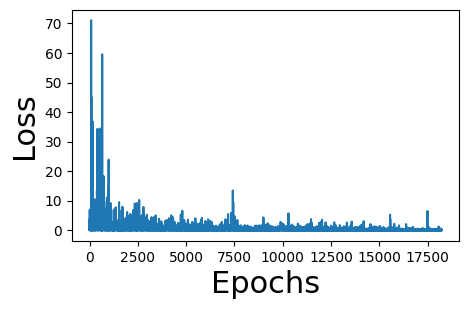

In [37]:
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [39]:
# test model
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [40]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [41]:
# 在 random 模式下，训练会失败
test_model(model, mode='random')

Initial State:
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 0; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 2; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 3; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 4; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 5; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 6; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 7; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['W' ' ' 'P' ' ']]
Move #: 8; Taking action: d
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 [

False

In [42]:
# 为了解决 catastrophic forgetting 问题，改进的 DQN with experience replay 训练方法，主要是采用随机批量训练
# DQN = deep Q network

In [59]:
from collections import deque

gamma = 0.9
epsilon = 0.3

epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0

for epoch in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1, -1)
    state1_ = state1_ + np.random.rand(*state1_.shape) / 100.0
    state1 = torch.from_numpy(state1_).float()
    game_over = 0
    move_step = 0
    while game_over == 0:
        qval = model(state1)
        qval_ = qval.data.numpy()
        
        if random.random() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        action = action_set[action_] # type: ignore
        game.makeMove(action)
        move_step += 1
        reward = game.reward()
        
        state2_ = game.board.render_np().reshape(1, -1)
        state2_ = state2_ + np.random.rand(*state2_.shape) / 100.0
        state2 = torch.from_numpy(state2_).float()
        
        done = True if reward > 0 else False
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)
                
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])   # torch.max 返回 (values, indices)
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze() # 有更好的写法。。。
            
            loss = loss_fn(X, Y.detach())
            print(epoch, loss.item())
            clear_output(wait=True)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
        if reward != -1 or move_step > max_moves:
            game_over = 1
            move_step = 0




4999 0.08952905982732773


In [ ]:
av_loss = [np.sum(np.array(losses[0:i]))/i for i in range(1, len(losses) + 1)]

Text(0, 0.5, 'Loss')

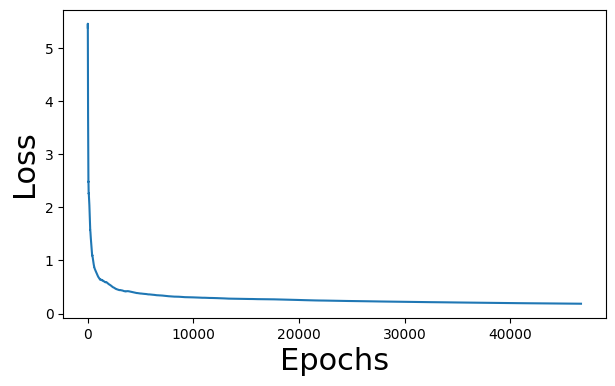

In [65]:
plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(av_loss))], av_loss)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [75]:
# testing model

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 824
Win percentage: 82.39999999999999%


In [76]:
# DQN with experience replay and target network

import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [77]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #A
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    game_over = 0
    mov = 0
    while game_over == 0: 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] # type: ignore
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            game_over = 1
            mov = 0

4999 0.01987295038998127


In [81]:
av_loss = [np.sum(np.array(losses[0:i]))/i for i in range(1, len(losses) + 1)]

Text(0, 0.5, 'Loss')

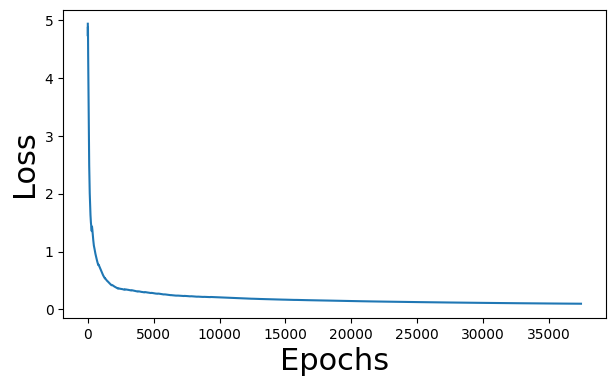

In [82]:
plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(av_loss))], av_loss)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [80]:
# testing model

max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 947
Win percentage: 94.69999999999999%


In [84]:
test_model(model, mode='random')

Initial State:
[[' ' ' ' ' ' ' ']
 ['P' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: r
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: u
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 7; Taking action: u
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 ['-' 'W' ' ' '+']
 [' ' ' ' ' ' ' ']]
Move #: 8; Taking action: u
[[' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [

True